In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import sys
import os
import scipy
import math
from sklearn.metrics import r2_score
from pathlib import Path
import subprocess

from Bio.SeqIO import read, parse
import orthoani

from multiprocess import Pool
import pandas as pd

max_pool = 16
lim_file = 200

sys.path.append('../')
sys.path.append('../../')


In [2]:
ANALYSIS_TYPE = "analysis_type"
ANALYSIS_DATA_DIR = "analysis_data_dir"
GENOME_FILE_1 = "genome_file_1"
GENOME_FILE_2 = "genome_file_2"
ORTHOANI_VAL = "orthoani_val"
KMER_LENGTH = "kmer_length"
C_VAL = "c_val"
CANONICAL = "canonical"
KMER_ANI_VAL = "kmer_ani_val"
PEARSON_COEFF = "pearson_coeff"
PEARSON_COEFF_PVAL = "pearson_coeff_pval"
SPEARMAN_COEFF = "spearman_coeff"
SPEARMAN_COEFF_PVAL = "spearman_coeff_pval"
R2_VAL_RAW = "r2_val_raw"
R2_VAL_LIN = "r2_val_lin"
DROPPED_ZEROS = "dropped_zeros"

In [3]:
data_home_dir = "../../data_temp"

species_analysis_type = "Single-Species"
species_analysis_data_dirs = {
    "Escherichia coli": (10,100),
    "Lactobacillus helveticus": (10,100),
    "Staphylococcus hominis": (10,100),
    "Mycoplasmoides pneumoniae": (10,100),
    "Brucella melitensis": (10,100),
    "Xanthomonas oryzae": (10,100)
}

genus_analysis_type = "Single-Genus"
genus_analysis_data_dirs = {
    "Pectobacterium": (10,35),
    "Morganella": (10,35),
    "Xylella": (10,35),
}

family_analysis_type = "Single-Family"
family_analysis_data_dirs = {
    "Enterobacteriaceae": (10,35),
    "Cyanobiaceae": (10,35),
    "Rhizobiaceae": (10,35)
}

family_genus_analysis_type = "Single-Family-Multi-Genus"
family_genus_analysis_data_dirs = {
    "31989": (10,35),
    "49546": (10,35),
    "186803": (10,35),
    "186817": (10,35),
}

genus_species_analysis_type = "Single-Genus-Multi-Species"
genus_species_analysis_data_dirs = {
    "Psychrobacter": (10,100),
    "Aeromonas": (10,100),
    "Rathayibacter": (10,100),
}

analysis_types = {
    species_analysis_type: species_analysis_data_dirs,
    genus_analysis_type: genus_analysis_data_dirs,
    family_analysis_type: family_analysis_data_dirs,
    family_genus_analysis_type: family_genus_analysis_data_dirs,
    genus_species_analysis_type: genus_species_analysis_data_dirs
}

In [4]:
ortho_ani_filename = "../../data_temp/ortho_ani_values.csv"
ortho_ani_dataframe = pd.read_csv(ortho_ani_filename,index_col=0)
print(ortho_ani_dataframe)

                                         genome_file_1  \
0       ../../data_temp/Single-Genus/Salmonella/64.fna   
1       ../../data_temp/Single-Genus/Salmonella/32.fna   
2       ../../data_temp/Single-Genus/Salmonella/99.fna   
3       ../../data_temp/Single-Genus/Salmonella/43.fna   
4        ../../data_temp/Single-Genus/Salmonella/7.fna   
..                                                 ...   
494  ../../data_temp/Single-Family/Rhizobiaceae/441...   
495  ../../data_temp/Single-Family/Rhizobiaceae/292...   
496  ../../data_temp/Single-Family/Rhizobiaceae/83.fna   
497  ../../data_temp/Single-Family/Rhizobiaceae/129...   
498  ../../data_temp/Single-Family/Rhizobiaceae/291...   

                                         genome_file_2  orthoani_val  \
0       ../../data_temp/Single-Genus/Salmonella/32.fna      0.985312   
1       ../../data_temp/Single-Genus/Salmonella/99.fna      0.984921   
2       ../../data_temp/Single-Genus/Salmonella/43.fna      0.983598   
3        ../../

In [5]:
kmer_sketch_ani_filename = "../../data_temp/kmer_sketch_ani_values.csv"
kmer_sketch_dataframe = pd.read_csv(kmer_sketch_ani_filename,index_col=0).replace(0,pd.NA).dropna()
print(kmer_sketch_dataframe)

                                         genome_file_1  \
0    ../../data_temp/Single-Species/Escherichia col...   
1    ../../data_temp/Single-Species/Escherichia col...   
2    ../../data_temp/Single-Species/Escherichia col...   
3    ../../data_temp/Single-Species/Escherichia col...   
4    ../../data_temp/Single-Species/Escherichia col...   
..                                                 ...   
494  ../../data_temp/Single-Family/Rhizobiaceae/441...   
495  ../../data_temp/Single-Family/Rhizobiaceae/292...   
496  ../../data_temp/Single-Family/Rhizobiaceae/83.fna   
497  ../../data_temp/Single-Family/Rhizobiaceae/129...   
498  ../../data_temp/Single-Family/Rhizobiaceae/291...   

                                         genome_file_2  kmer_length  c_val  \
0    ../../data_temp/Single-Species/Escherichia col...           10    200   
1    ../../data_temp/Single-Species/Escherichia col...           10    200   
2    ../../data_temp/Single-Species/Escherichia col...           10  

In [6]:
corrleation_filename = "../../data_temp/correlation_values.csv"
correlation_dataframe = pd.read_csv(corrleation_filename,index_col=0)
print(correlation_dataframe)

    kmer_length  c_val  canonical  pearson_coeff  pearson_coeff_pval  \
0            10     20       True       0.907790        2.218581e-38   
0            10     20      False       0.421223        1.413929e-05   
0            10     50       True       0.911519        3.280371e-39   
0            10     50      False       0.425088        1.155857e-05   
0            10    100       True       0.916422        2.327374e-40   
..          ...    ...        ...            ...                 ...   
0            31    200       True       0.997971        0.000000e+00   
0            32    200       True       0.998233        0.000000e+00   
0            33    200       True       0.998213        0.000000e+00   
0            34    200       True       0.998040        0.000000e+00   
0            35    200       True       0.997898        0.000000e+00   

    spearman_coeff  spearman_coeff_pval   analysis_type analysis_data_dir  \
0         0.866259         5.424778e-31  Single-Species  E

In [7]:
orthoani_values = ortho_ani_dataframe[ORTHOANI_VAL]

In [8]:
print(orthoani_values)

0      0.985312
1      0.984921
2      0.983598
3      0.984154
4      0.986997
         ...   
494    0.780533
495    0.781226
496    0.994015
497    0.997140
498    0.997200
Name: orthoani_val, Length: 2586, dtype: float64


In [9]:
log_orthoani_values = np.log(1 - orthoani_values)
print(log_orthoani_values)

0     -4.220711
1     -4.194440
2     -4.110354
3     -4.144817
4     -4.342611
         ...   
494   -1.516556
495   -1.519717
496   -5.118467
497   -5.857096
498   -5.878066
Name: orthoani_val, Length: 2586, dtype: float64


(array([647., 646., 646., 647.]),
 array([0.62316053, 0.81276085, 0.9629068 , 0.99568977, 0.99986175]),
 <BarContainer object of 4 artists>)

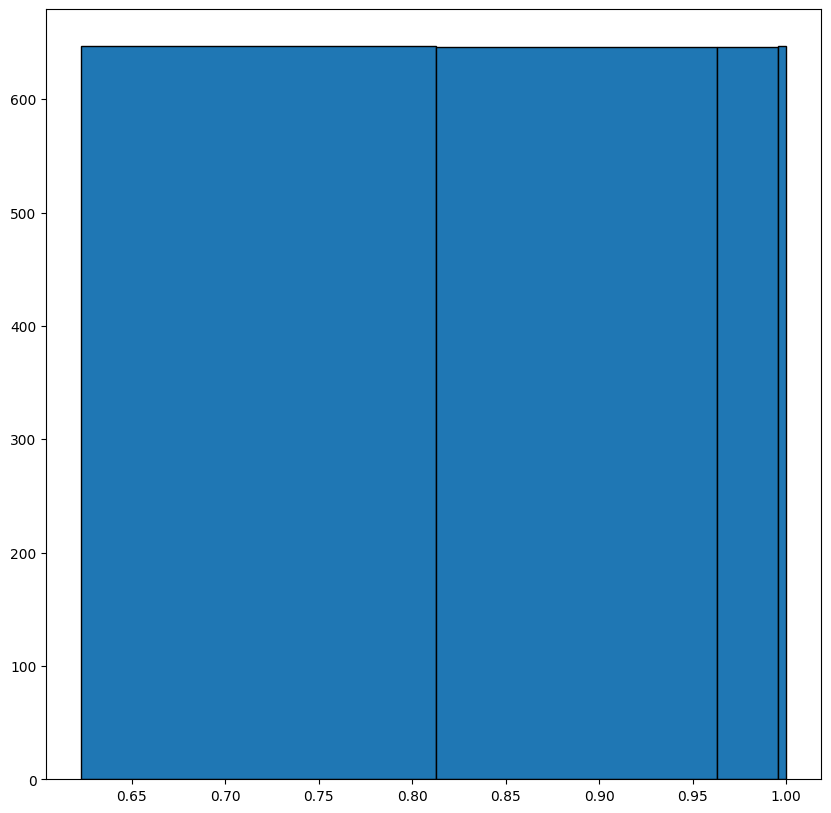

In [10]:
num_bins = 4+1
quantile = np.linspace(0,1,num_bins)
bin_edges = np.quantile(orthoani_values,quantile)
plt.figure(figsize=(10,10))
plt.hist(orthoani_values,bins=bin_edges,edgecolor="black")

In [11]:
print(bin_edges)

[0.62316053 0.81276085 0.9629068  0.99568977 0.99986175]


In [12]:
bin_ranges = [(b1,b2) for b1,b2 in zip(bin_edges,bin_edges[1:])]
print(bin_ranges)

[(0.6231605263157894, 0.8127608491845619), (0.8127608491845619, 0.9629068021410866), (0.9629068021410866, 0.9956897666084026), (0.9956897666084026, 0.9998617485998756)]


In [13]:
def partition_dataframe(dataframe, column, bin_ranges):
    return [
        dataframe[
            (dataframe[column] > st)
            & (dataframe[column] < ed)
        ] 
        for st,ed in bin_ranges
    ]

In [14]:
ortho_ani_partitioned = partition_dataframe(ortho_ani_dataframe,ORTHOANI_VAL,bin_ranges)
print(len(ortho_ani_partitioned))

4


In [15]:
combined_partitions = [
    pd.merge(
        ortho_df,
        kmer_sketch_dataframe,
        how="left",
    )
    for ortho_df in ortho_ani_partitioned
]
print(combined_partitions[-1])

                                           genome_file_1  \
0         ../../data_temp/Single-Genus/Salmonella/58.fna   
1         ../../data_temp/Single-Genus/Salmonella/46.fna   
2          ../../data_temp/Single-Genus/Salmonella/9.fna   
3         ../../data_temp/Single-Genus/Salmonella/49.fna   
4         ../../data_temp/Single-Genus/Salmonella/63.fna   
...                                                  ...   
33231  ../../data_temp/Single-Family/Rhizobiaceae/291...   
33232  ../../data_temp/Single-Family/Rhizobiaceae/291...   
33233  ../../data_temp/Single-Family/Rhizobiaceae/291...   
33234  ../../data_temp/Single-Family/Rhizobiaceae/291...   
33235  ../../data_temp/Single-Family/Rhizobiaceae/291...   

                                           genome_file_2  orthoani_val  \
0         ../../data_temp/Single-Genus/Salmonella/90.fna      0.996129   
1         ../../data_temp/Single-Genus/Salmonella/52.fna      0.995909   
2         ../../data_temp/Single-Genus/Salmonella/86.fna 

In [16]:
combined_partitions = [
    partition[
        (partition[CANONICAL] == True)
        & (partition[C_VAL] == 200)
    ]
    for partition in combined_partitions
]
for partition in combined_partitions:
    print(set(partition[C_VAL]),set(partition[CANONICAL]))

{200} {True}
{200.0} {True}
{200.0} {True}
{200.0} {True}


In [17]:
def plot_ani_vals(dataframe, kmer_length, canonical, c_val):
    fig = plt.figure(figsize=(10,10),dpi=300)
    ax = fig.add_subplot()
    
    print(set(dataframe[ANALYSIS_TYPE]))
        
    restricted_dataframe = dataframe[
        (dataframe[KMER_LENGTH] == kmer_length)
        & (dataframe[CANONICAL] == canonical)
        & (dataframe[C_VAL] == c_val)
    ]
    ortho_vals = restricted_dataframe[ORTHOANI_VAL]
    kmer_sketch_vals = restricted_dataframe[KMER_ANI_VAL]
    ax.scatter(ortho_vals,kmer_sketch_vals,s=[2 for _ in ortho_vals])
    ax.scatter(ortho_vals,ortho_vals,s=[2 for _ in ortho_vals])
    

{'Single-Family'}


/tmp/ipykernel_60365/2091468763.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


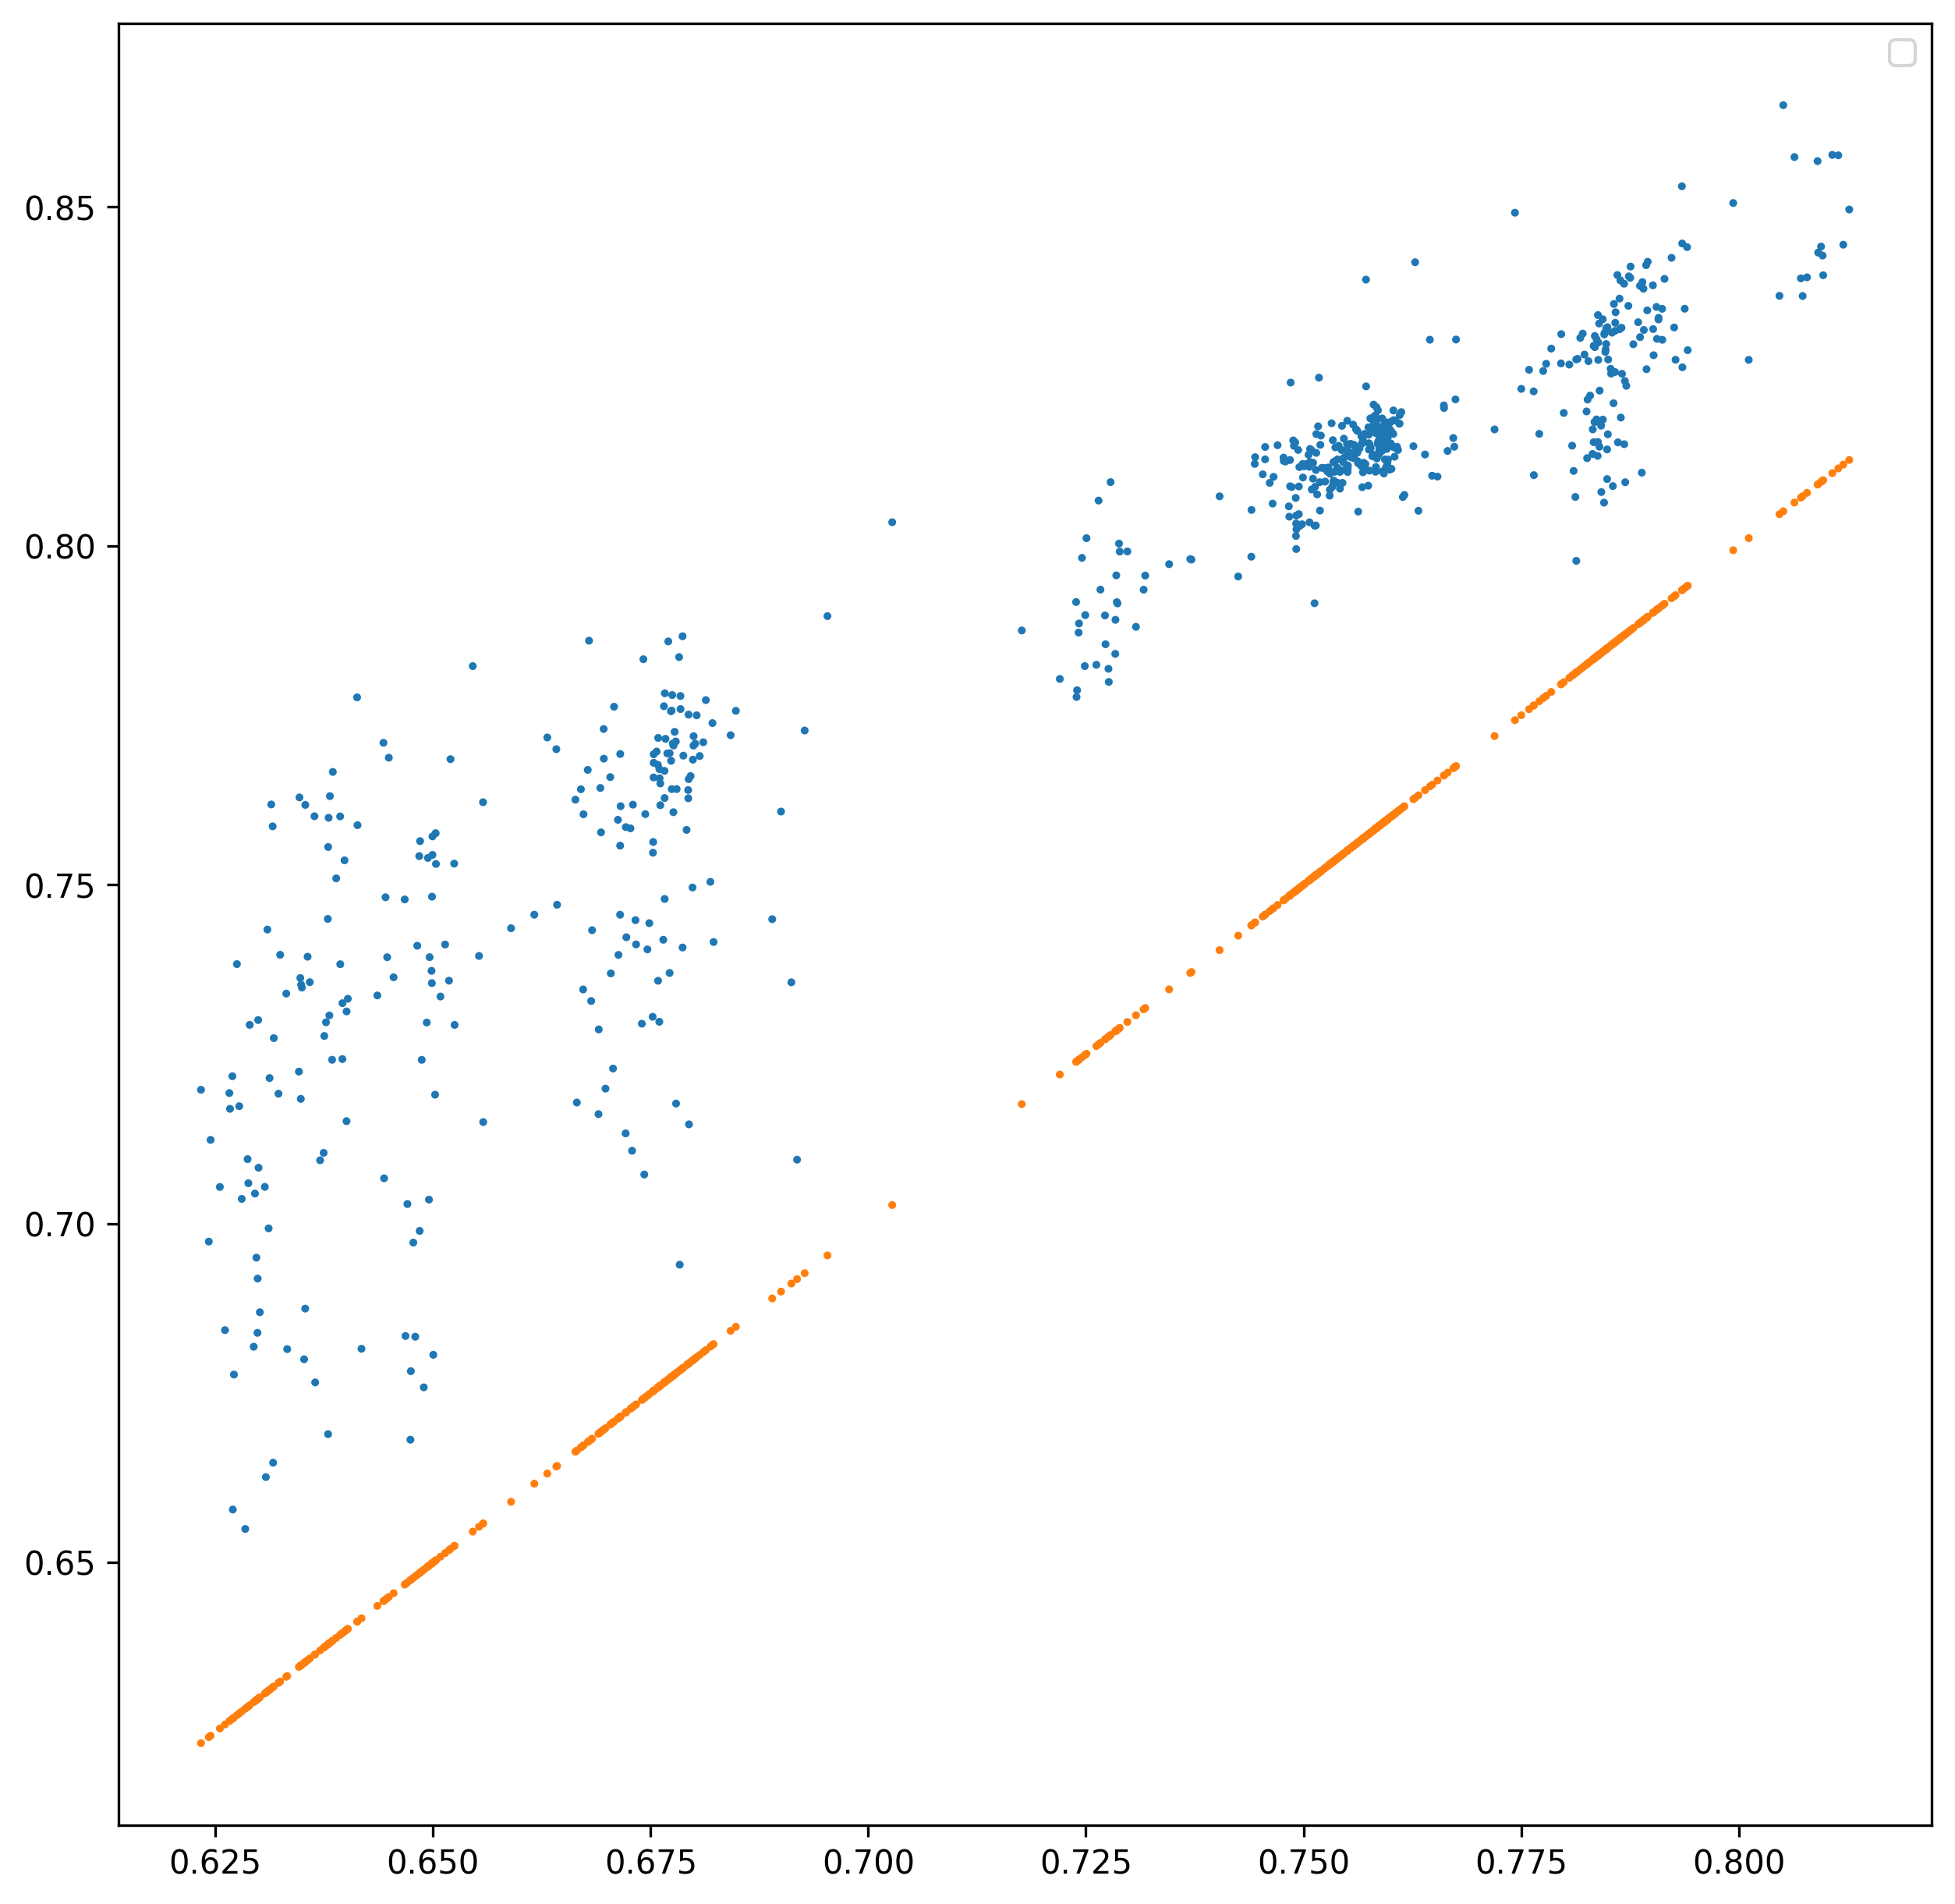

In [18]:
plot_ani_vals(combined_partitions[0],23,True,200)

{'Single-Genus', 'Single-Species', 'Single-Family'}


/tmp/ipykernel_60365/2091468763.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


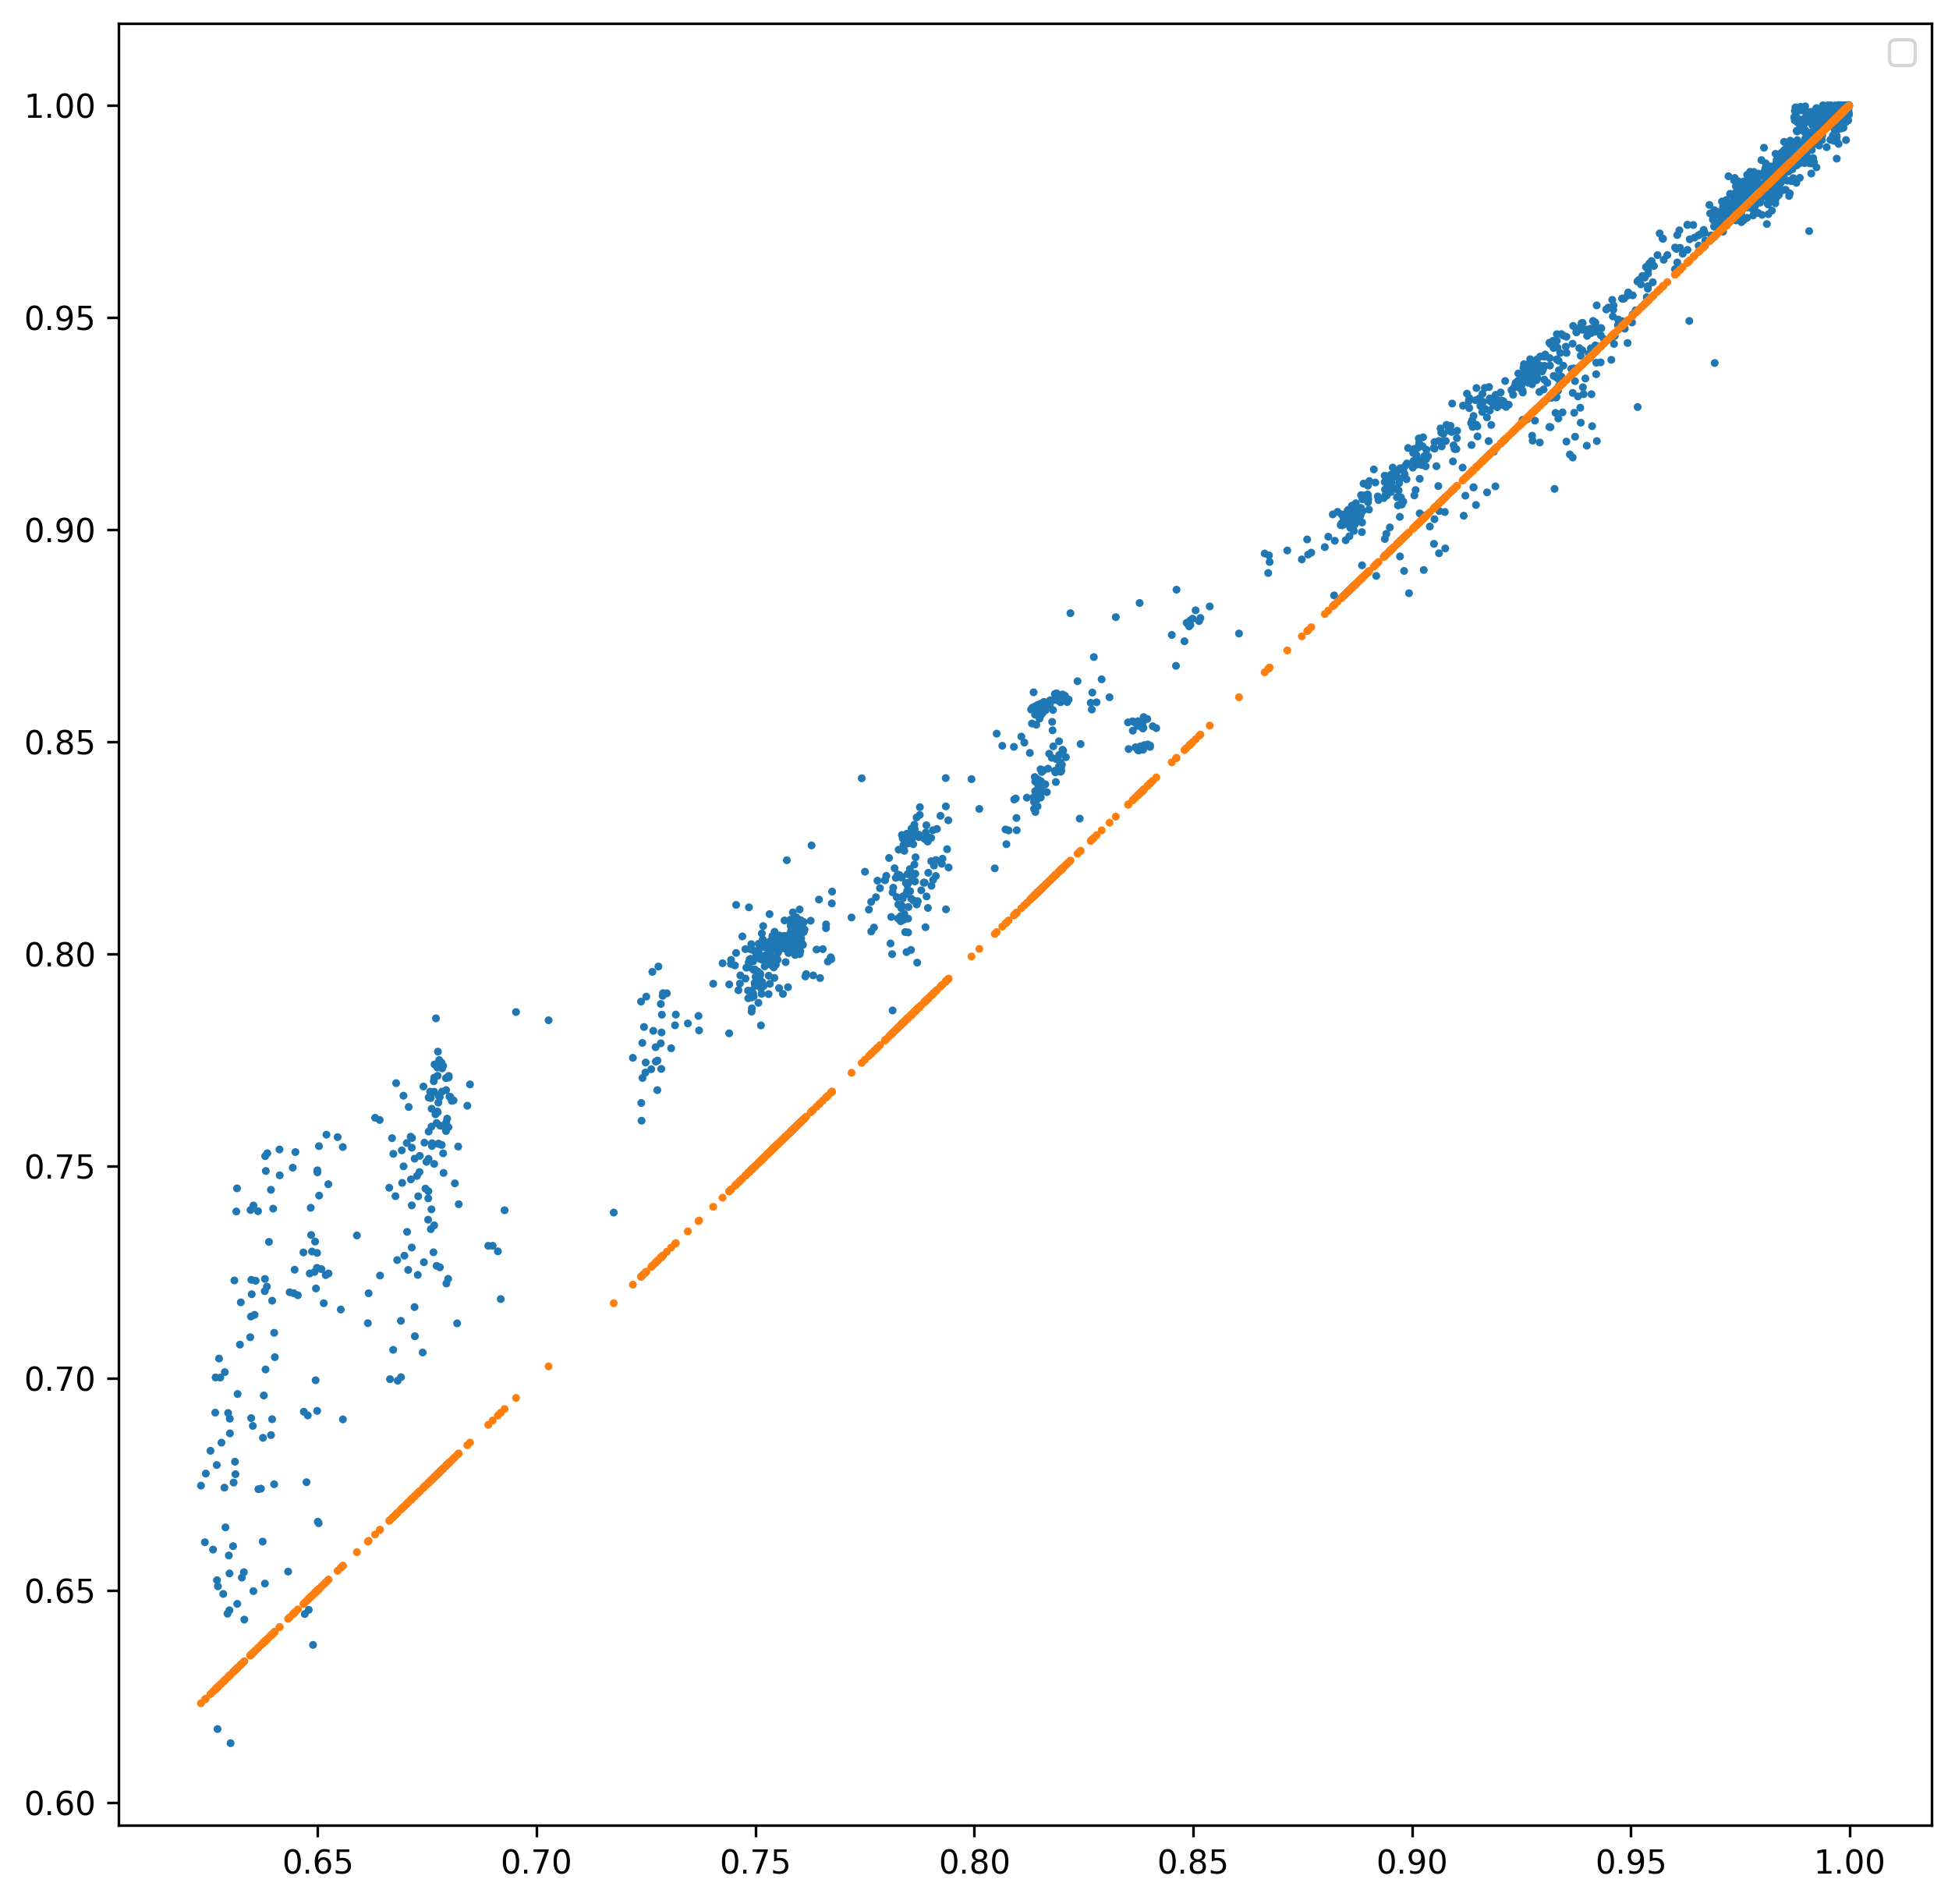

In [19]:
plot_ani_vals(
    pd.merge(
        ortho_ani_dataframe,
        kmer_sketch_dataframe,
        how="left",
    ).replace(0,pd.NA).dropna()
    ,20,True,200)


In [20]:
for partition in combined_partitions:
    print(partition[[ORTHOANI_VAL,KMER_ANI_VAL]])
    
        

       orthoani_val kmer_ani_val
0          0.761057     0.827394
1          0.761057     0.808177
2          0.761057     0.808676
3          0.761057     0.802555
4          0.761057      0.80512
...             ...          ...
15255      0.781226     0.833315
15256      0.781226     0.838785
15257      0.781226     0.840656
15258      0.781226     0.842871
15259      0.781226     0.840393

[15260 rows x 2 columns]
       orthoani_val kmer_ani_val
13         0.902798      0.99582
14         0.902798     0.982047
15         0.902798     0.958234
16         0.902798      0.93365
17         0.902798     0.920031
...             ...          ...
15451      0.818047     0.875179
15452      0.818047     0.874967
15453      0.818047     0.874897
15454      0.818047     0.879678
15455      0.818047      0.87978

[15443 rows x 2 columns]
       orthoani_val kmer_ani_val
139        0.983812      0.99728
140        0.983812     0.990386
141        0.983812     0.982891
142        0.983812     

10 36
(0.4479957665205001, 18)
{'Single-Family'}
10.0 36.0
(0.8762886890252573, 17)
{'Single-Genus', 'Single-Family'}
10.0 101.0


/tmp/ipykernel_60365/2091468763.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/tmp/ipykernel_60365/2091468763.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


(0.6586598578514095, 20)
{'Single-Genus', 'Single-Species', 'Single-Family'}
10.0 101.0


/tmp/ipykernel_60365/2091468763.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


(0.3353214434258758, 33)
{'Single-Genus', 'Single-Species', 'Single-Family'}


/tmp/ipykernel_60365/2091468763.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


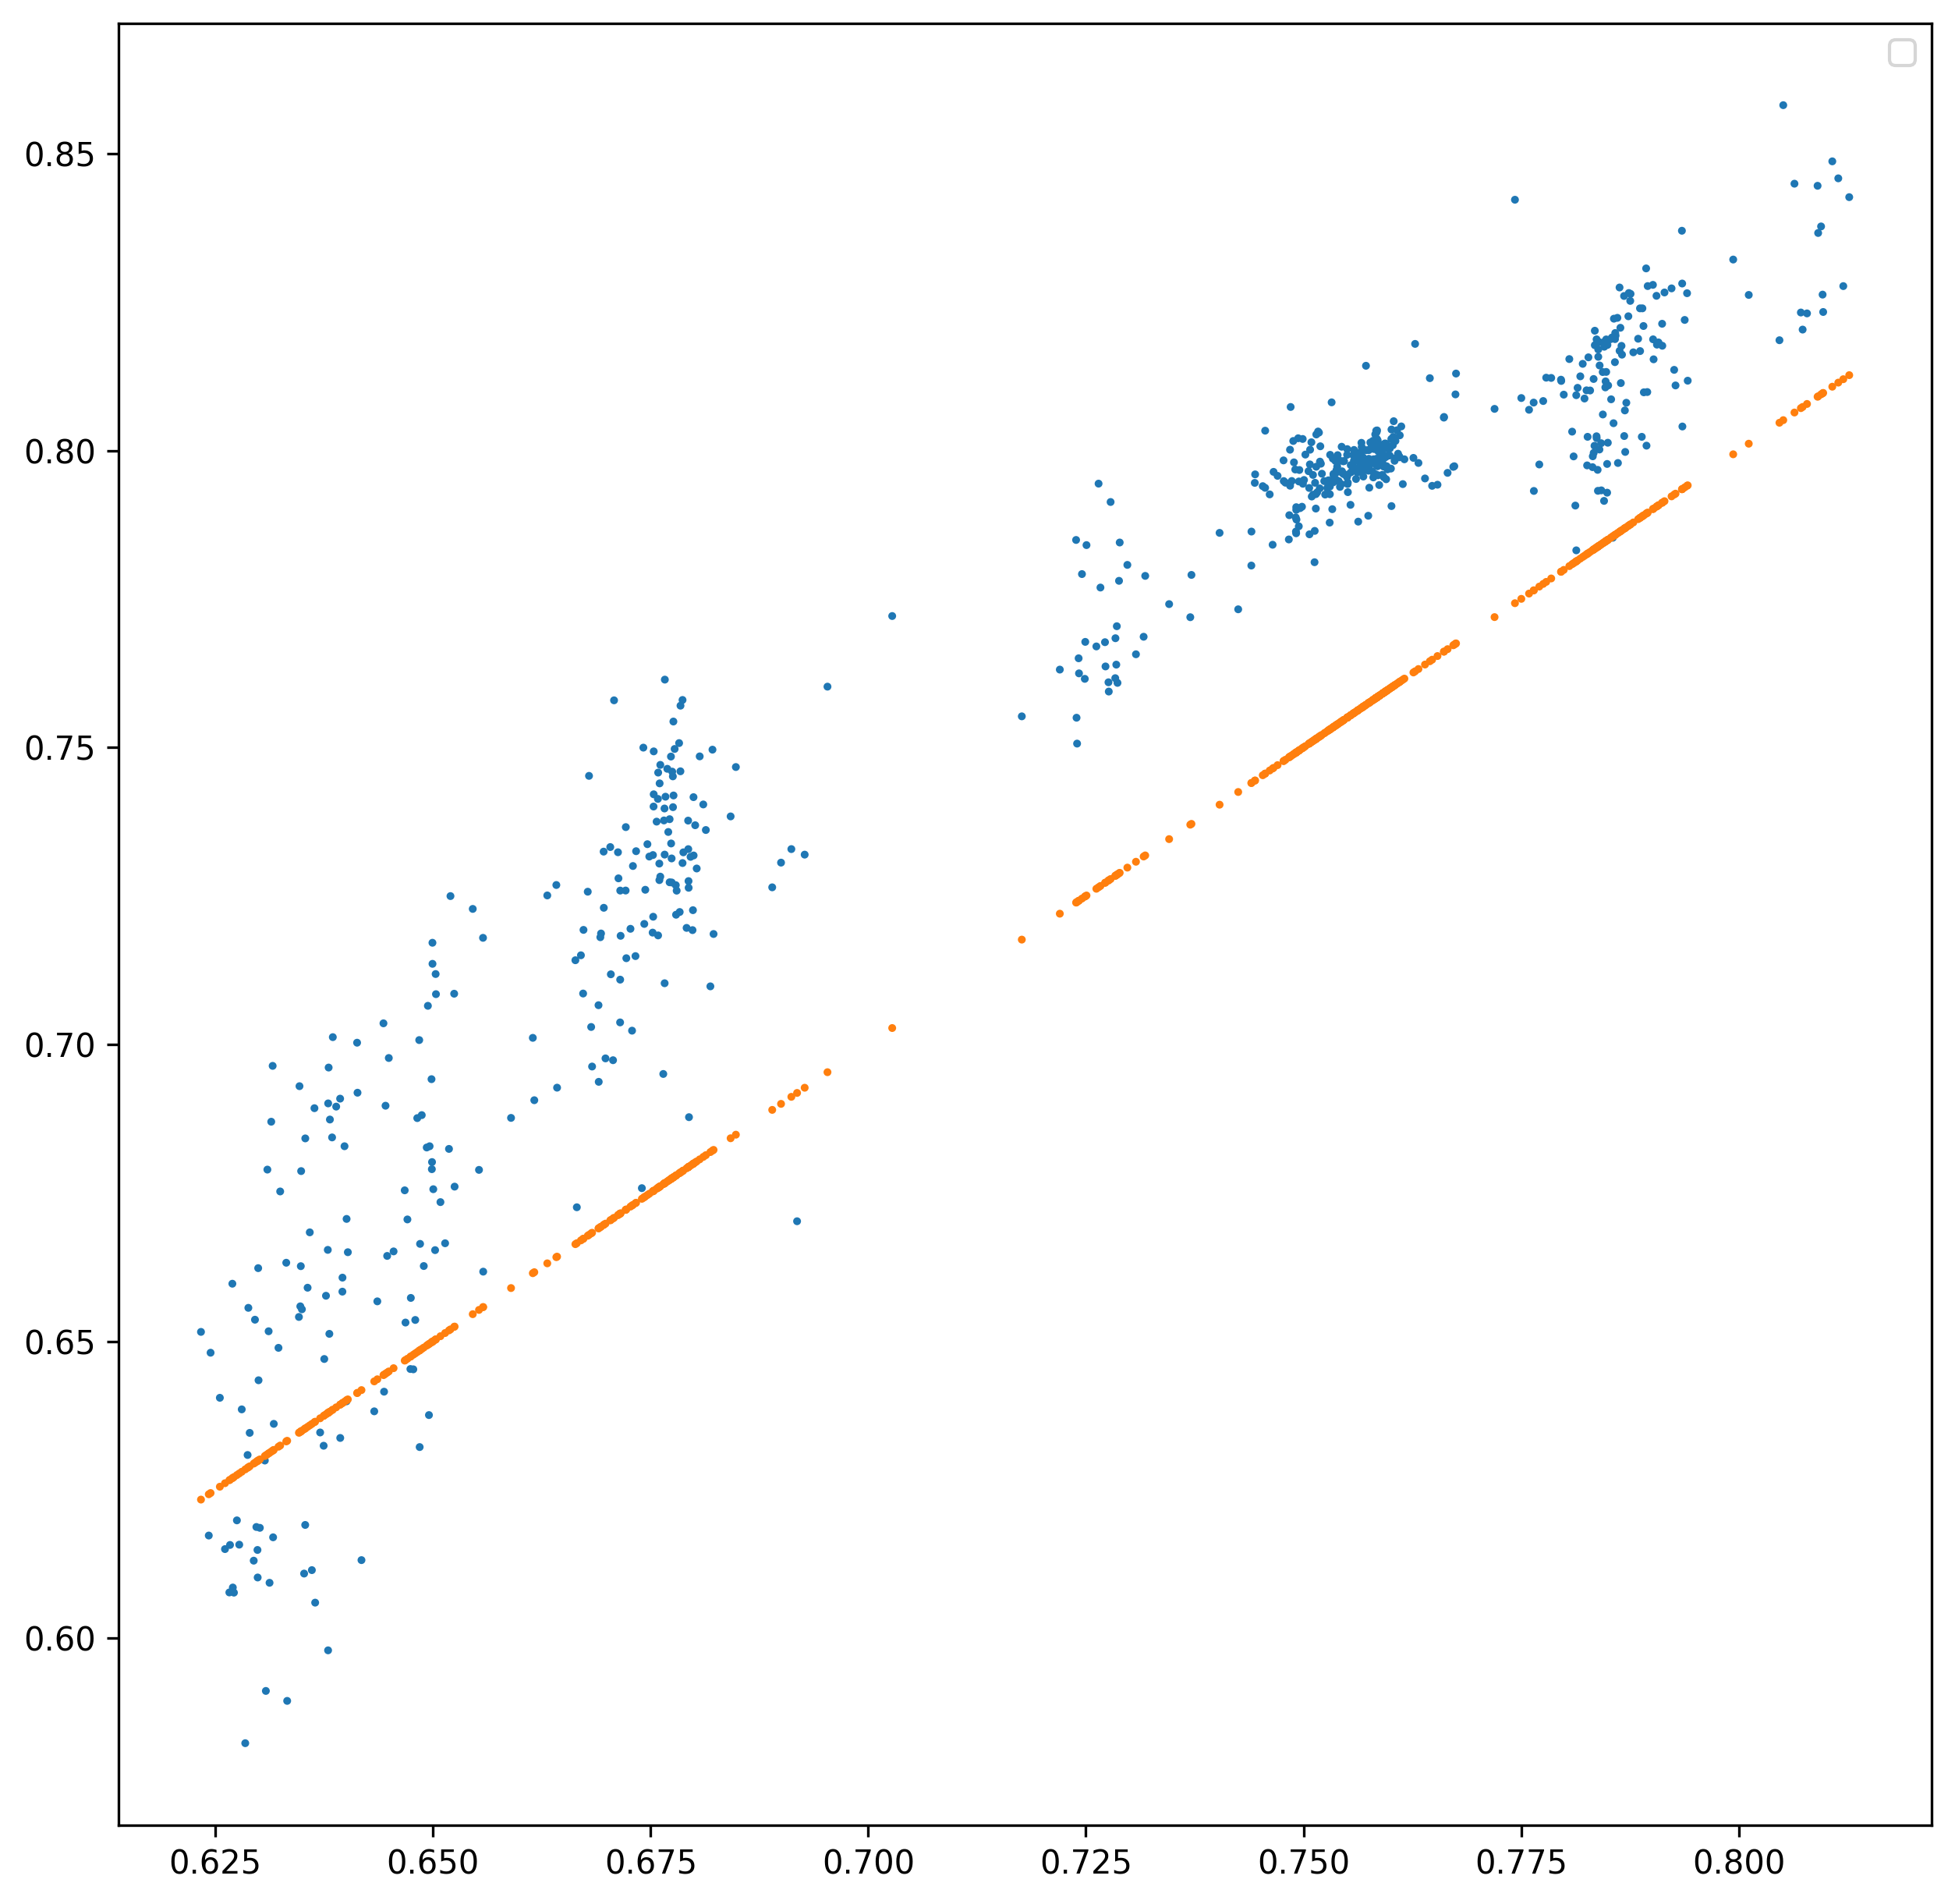

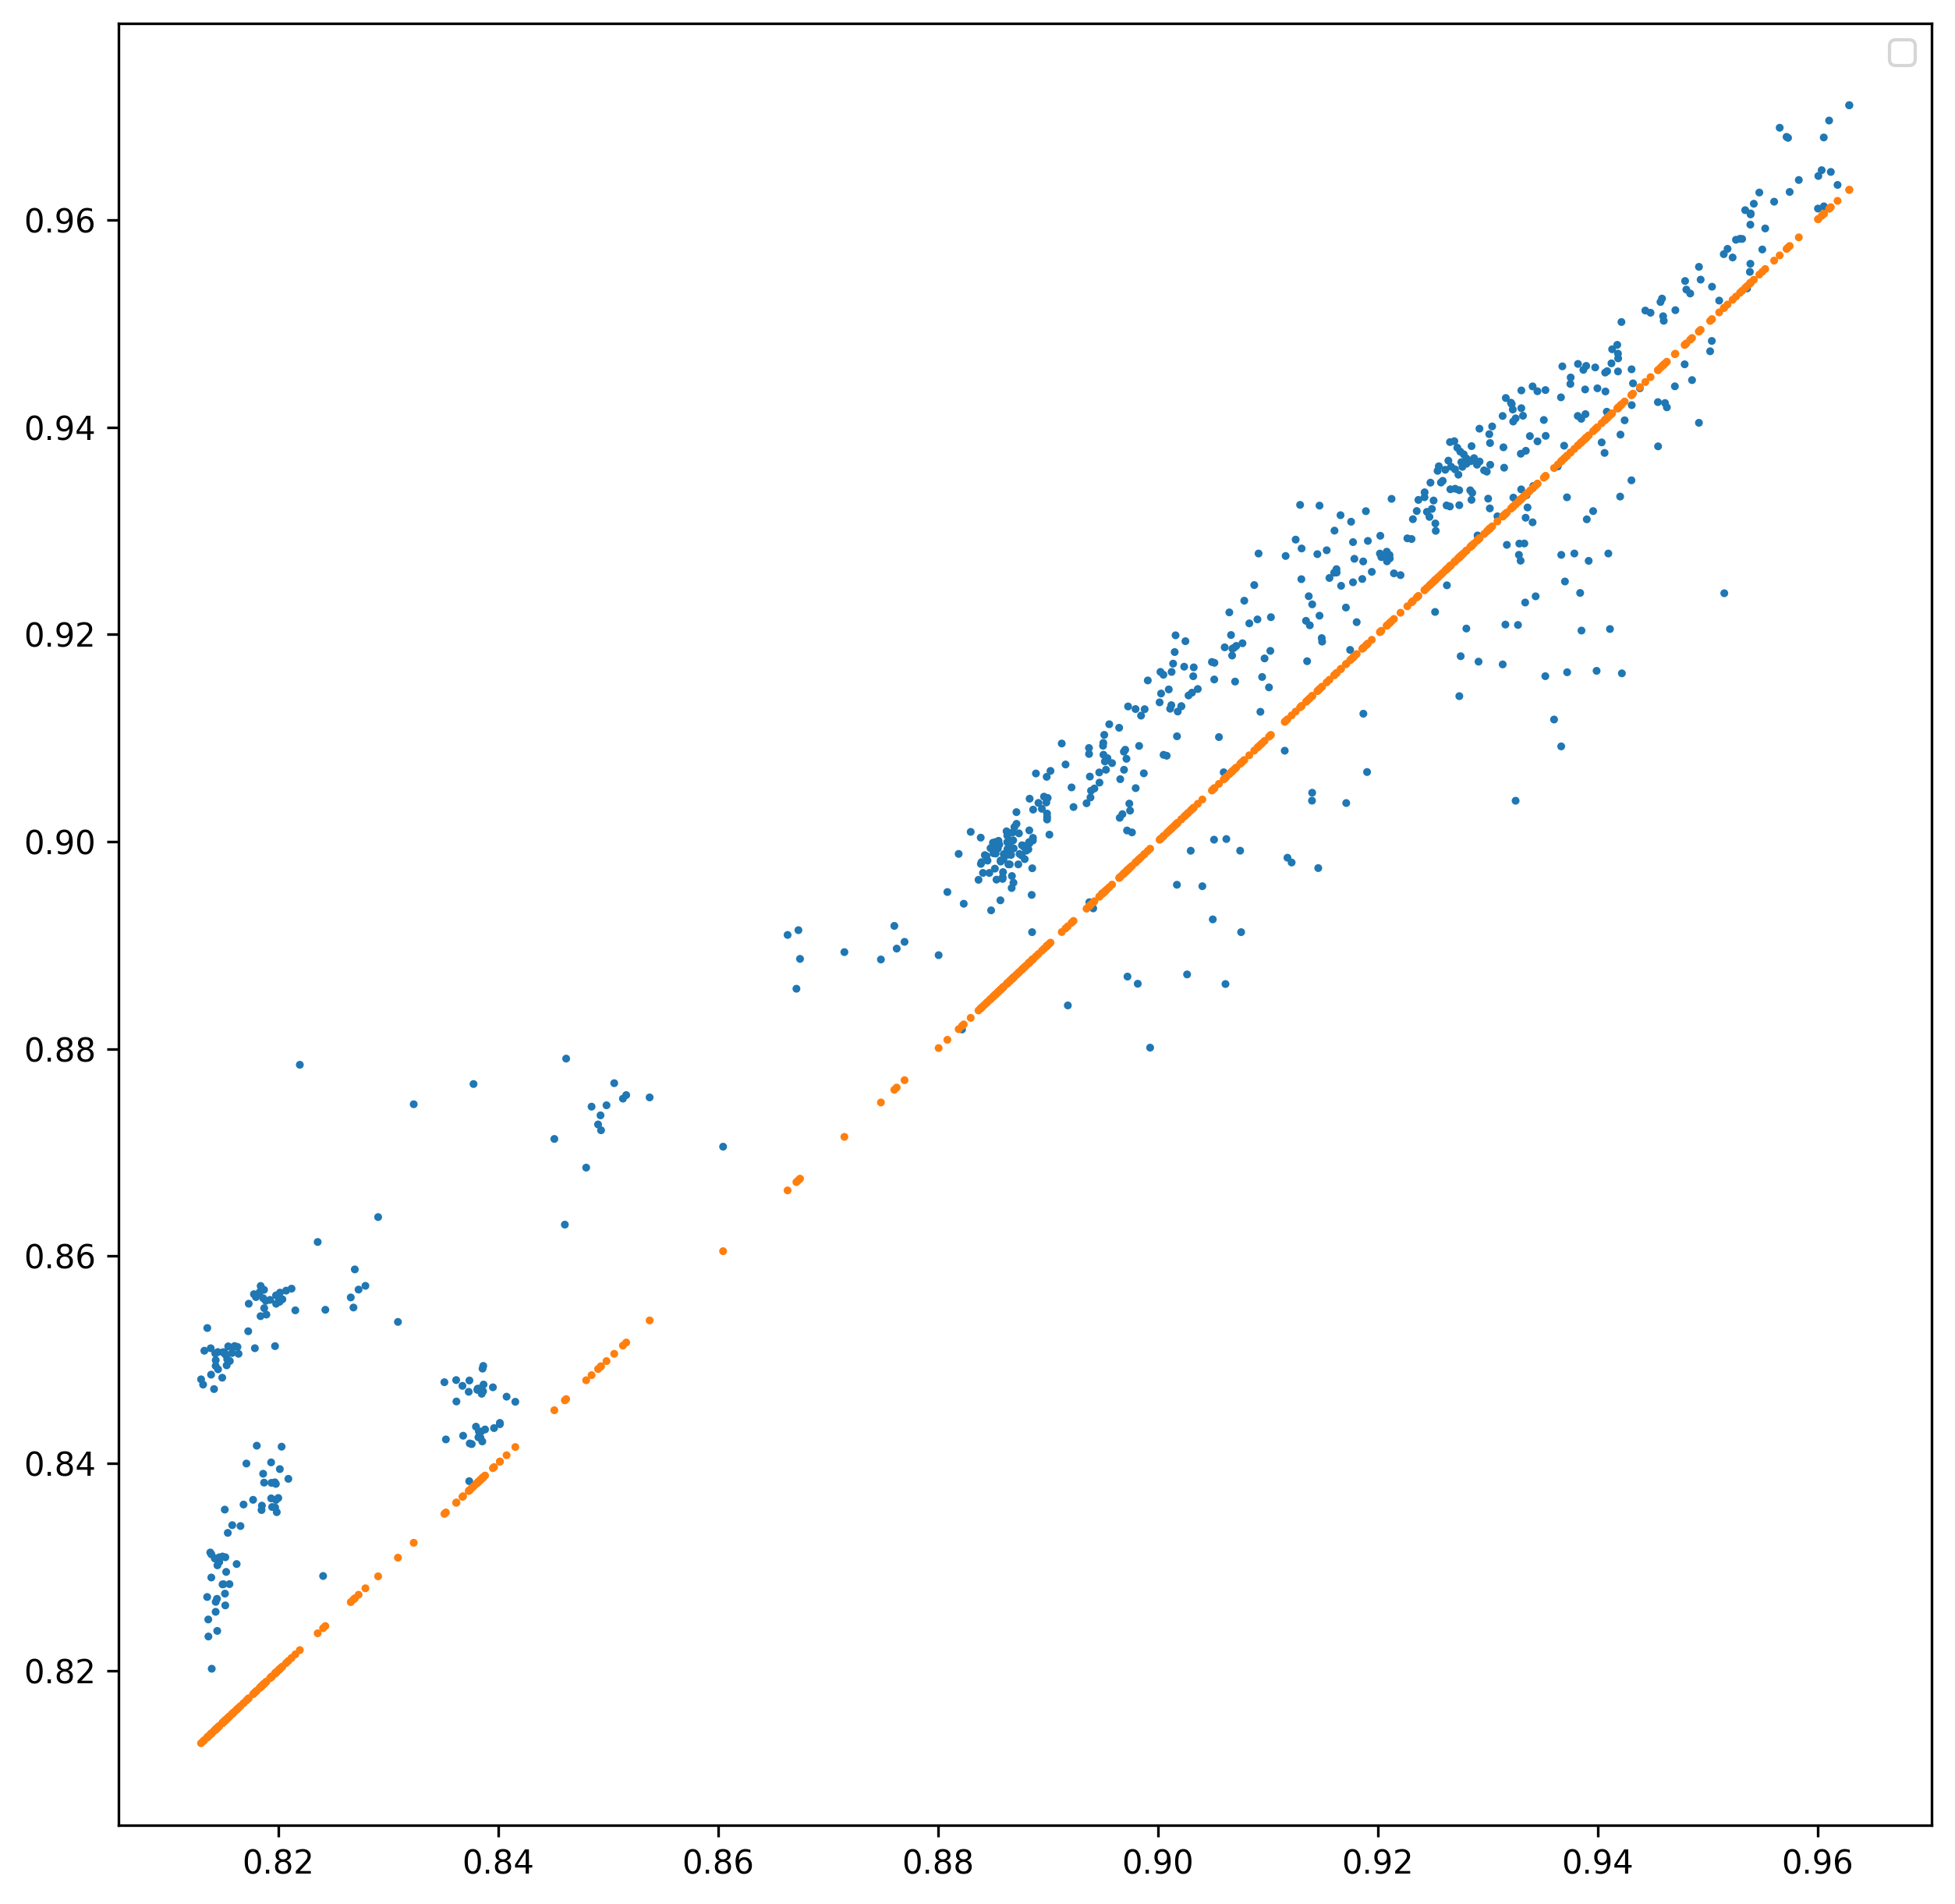

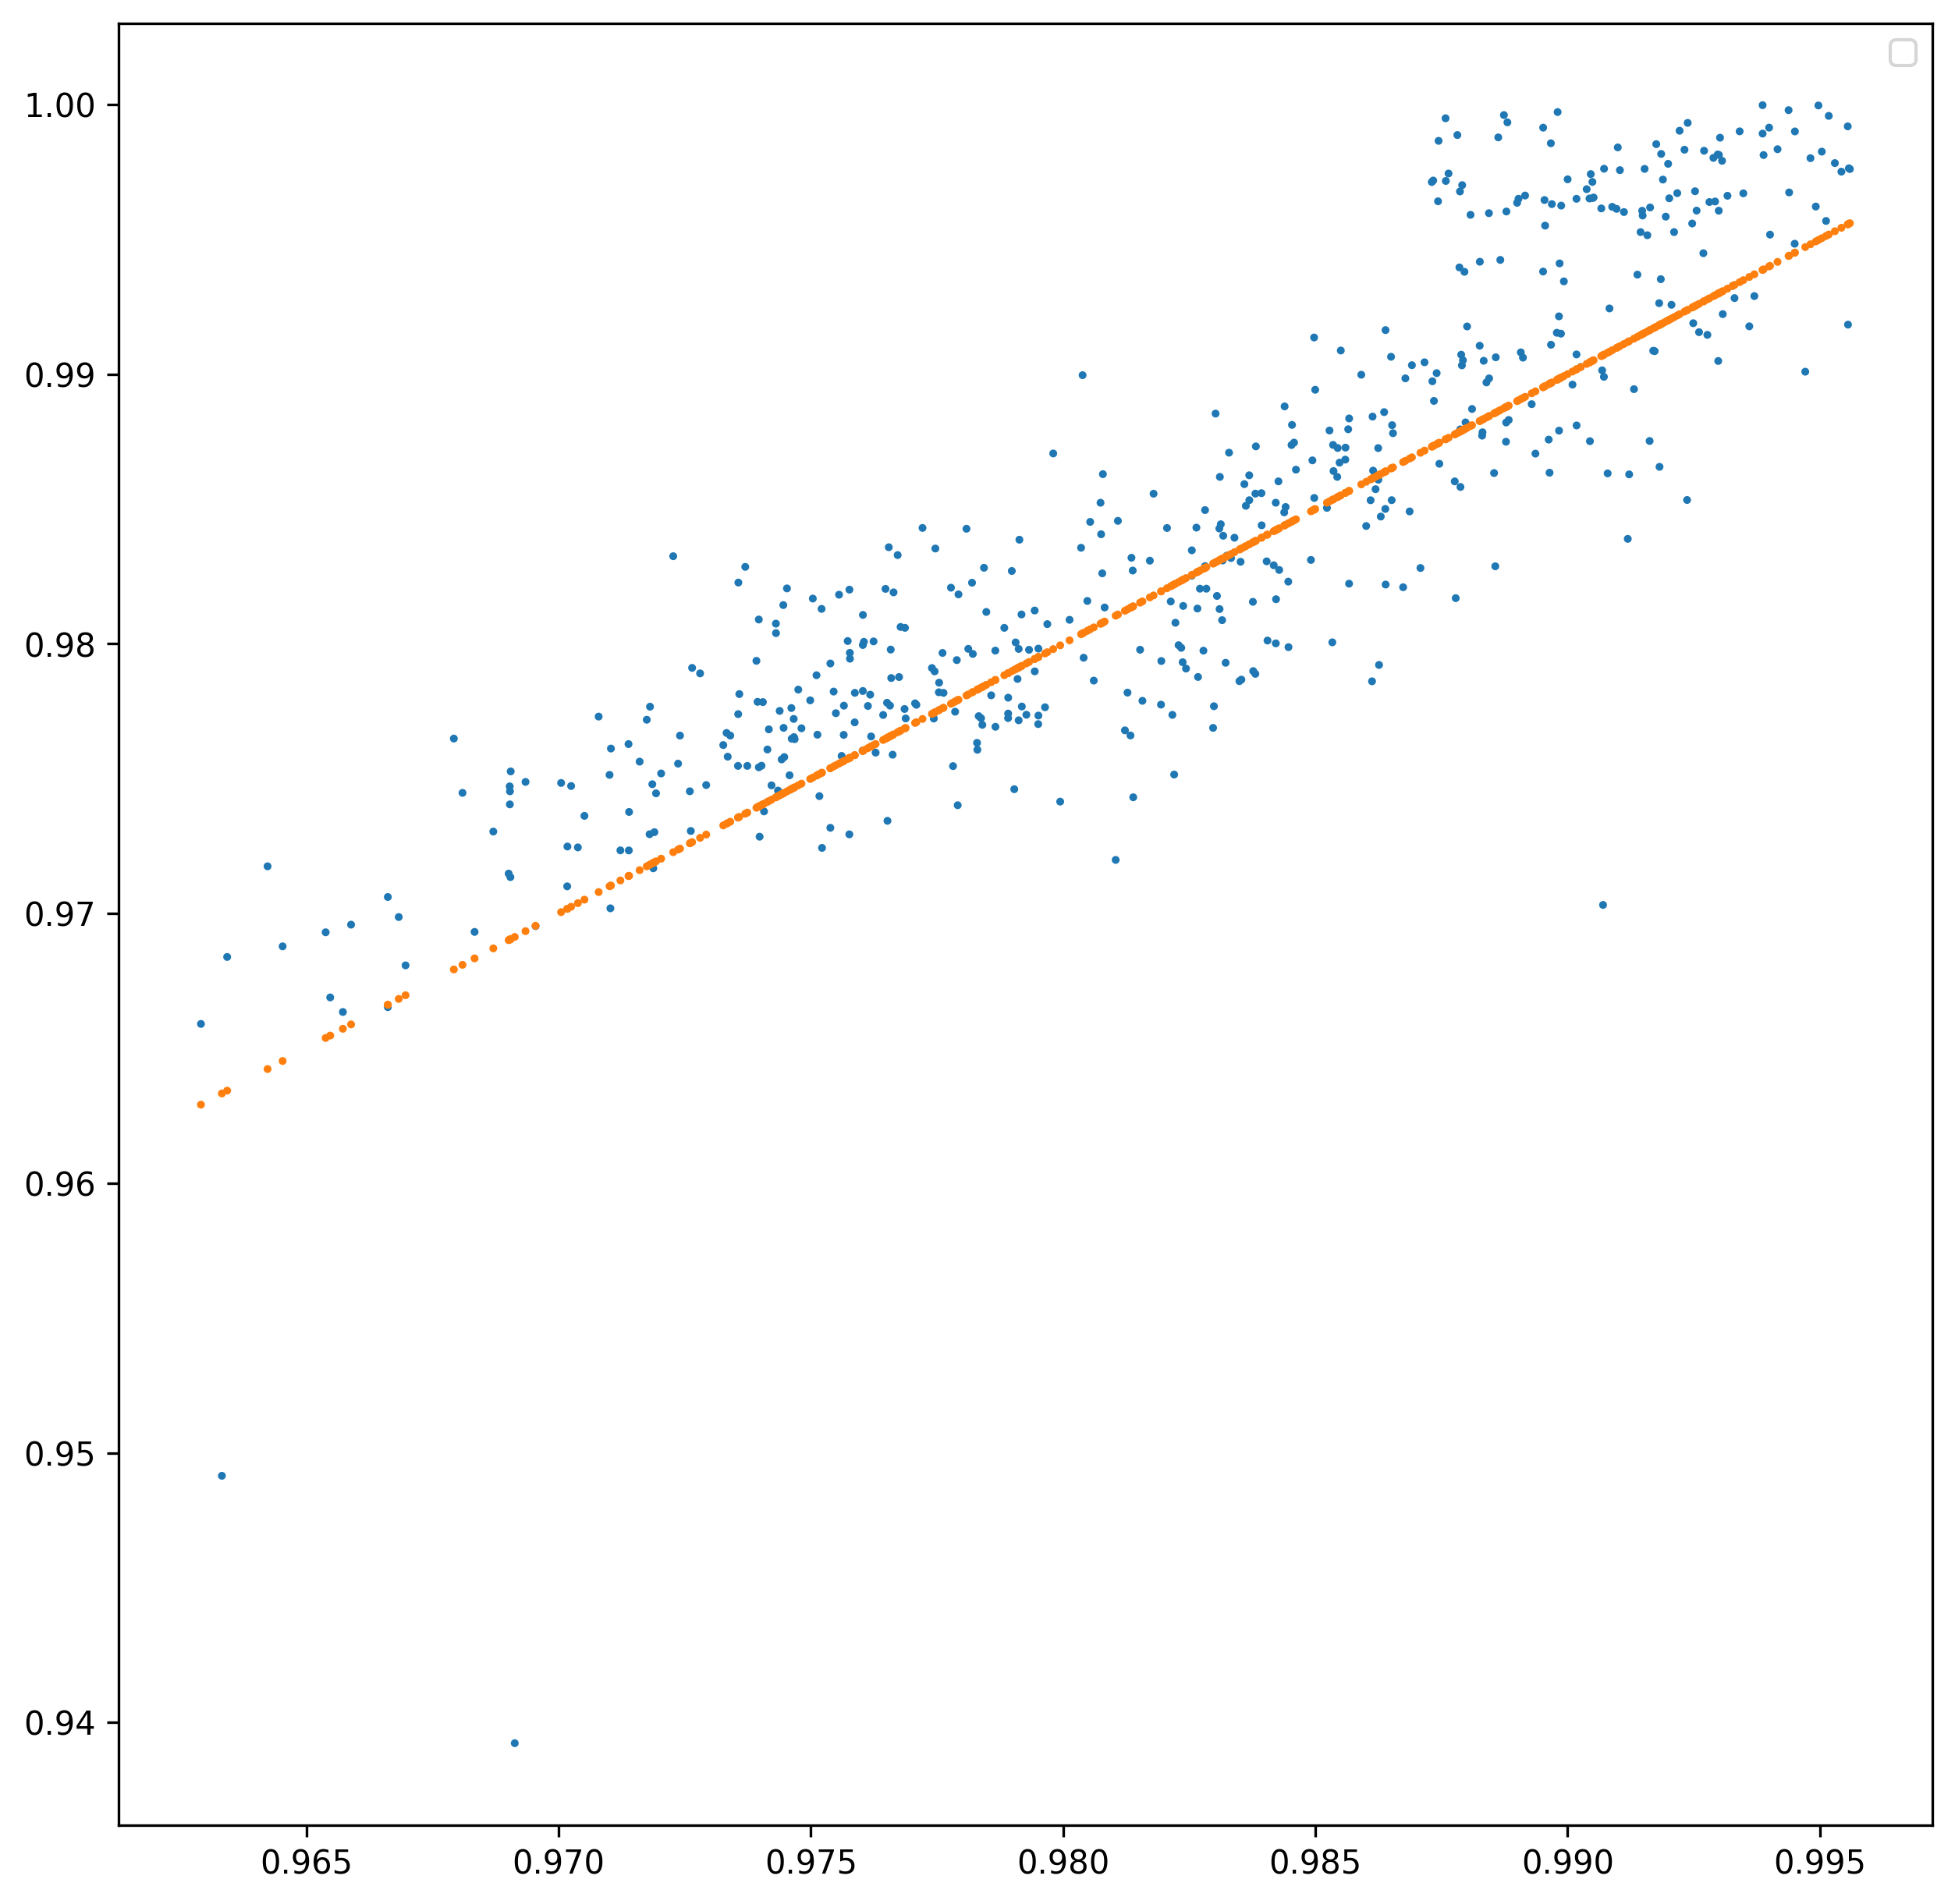

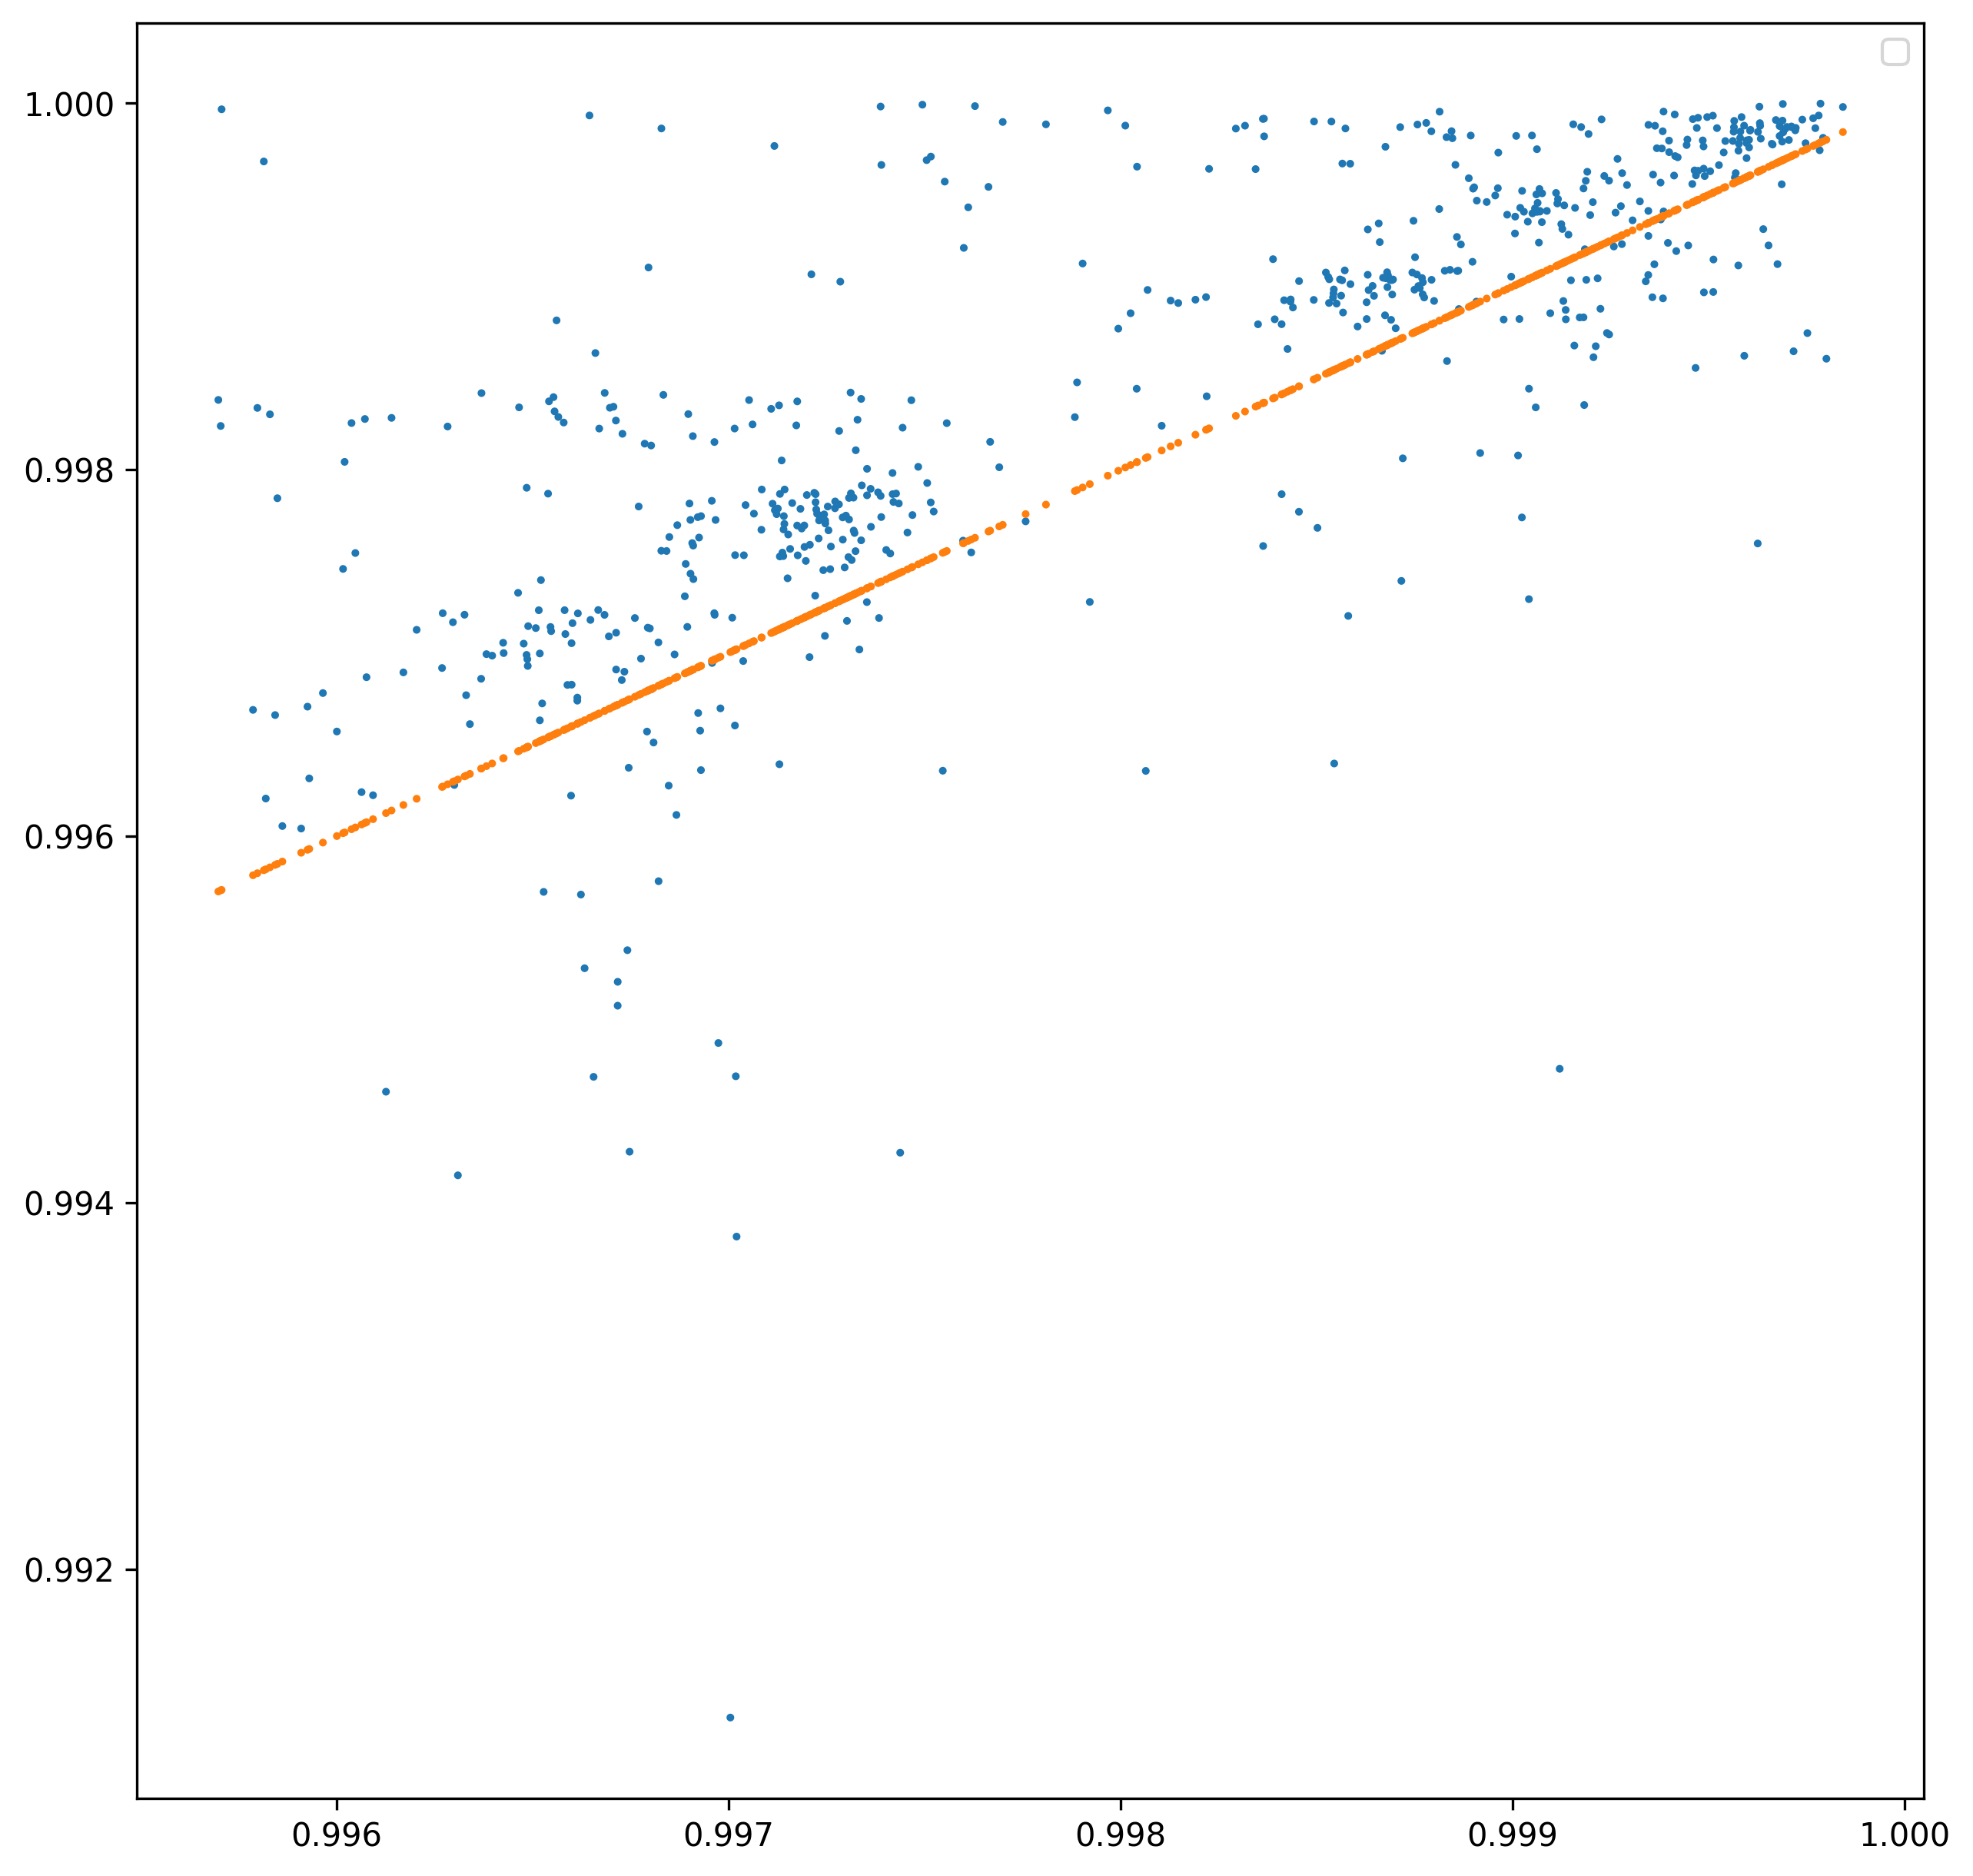

In [21]:
for partition in combined_partitions:
    print(min(partition[KMER_LENGTH]),max(partition[KMER_LENGTH]+1))
    best_val = max([   
            (r2_score(
                partition[partition[KMER_LENGTH] == kmer_length][ORTHOANI_VAL],
                partition[partition[KMER_LENGTH] == kmer_length][KMER_ANI_VAL],
            ),
            kmer_length,
            )
            for kmer_length in range(
                int(min(partition[KMER_LENGTH])),int(max(partition[KMER_LENGTH]+1))
            )
        ])
    print(best_val)
    plot_ani_vals(partition,best_val[1],True,200)
    
    
        